# Compute pRF cortical magnification base on pRF parameters 

In [14]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Import 
import time
import numpy as np
import pandas as pd
from scipy import stats
import neuropythy as ny
import matplotlib.pyplot as plt
import scipy.sparse.csgraph as cs
import importlib

# personal import 
from plot_utils import plotly_template, prf_ecc_pcm_plot
from math_utils import weighted_regression, weighted_nan_percentile, weighted_nan_median



# Geodesic distance (mm)

In [2]:
def compute_geodesic_distance(vert_of_interest_idx, adjacency_matrix):
    
    distances = cs.dijkstra(adjacency_matrix, 
                            indices=[vert_of_interest_idx], 
                            directed=False)

    median_distance = np.median(distances)

    return median_distance
    

# Visual distance (dva)

In [3]:
def compute_pRF_distance(vert_of_interest_idx, roi_vertices_hemi_mask, prf_x, prf_y):
    
    dist_array = []
    for vert_num, vert_idx in enumerate(roi_vertices_hemi_mask):
        # Acces pRF position
        target_x = prf_x[vert_of_interest_idx]
        target_y = prf_y[vert_of_interest_idx]
        neigboor_x = prf_x[vert_idx]
        neigboor_y = prf_y[vert_idx]
    
        # Compute visual distance
        vert_prf_dist_array_vert = np.sqrt((target_x - neigboor_x)**2 + (target_y - neigboor_y)**2)
        dist_array.append(vert_prf_dist_array_vert)

    # compute the median of visual distance
    vert_prf_dist_array_median = np.median(dist_array)
    
    return vert_prf_dist_array_median
    

# Compute de pRF CM (mm/dva)

## Acces data

In [8]:
# Settings 
subject_id = 111312
hemis = 'lh'
hemis = ['lh','rh']
roi = 'V1'
rois = ['V1', 'V2', 'V3']
plot_groups = [['V1'],['V2'],['V3']]
roi_code = {'V1':1, 
            'V2':2, 
            'V3':3}

num_ecc_pcm_bins = 6
max_ecc = 8

In [5]:
# Load an HCP subject:
sub = ny.hcp_subject(subject_id)

# Get rois boundery
sub = ny.data['hcp_lines'].subjects[subject_id]

## pRF CM computation

In [6]:
prf_CM_df = pd.DataFrame()
start_time = time.time()

for n_hemi, hemi in enumerate(hemis): 
    for roi in rois : 
        # ROI mask et paramètres
        if hemi == 'lh':
            label_roi = sub.lh.prop('visual_area')
            prf_x_hemi = sub.lh.prop('prf_x')
            prf_y_hemi = sub.lh.prop('prf_y')
            prf_r2_hemi = sub.lh.prop('prf_variance_explained')
            prf_ecc_hemi = sub.lh.prop('prf_eccentricity')
            
            white = sub.lh.surface('white') 
        else:
            label_roi = sub.rh.prop('visual_area')
            prf_x_hemi = sub.rh.prop('prf_x')
            prf_y_hemi = sub.rh.prop('prf_y')
            prf_r2_hemi = sub.rh.prop('prf_variance_explained')
            prf_ecc_hemi = sub.rh.prop('prf_eccentricity')
            white = sub.rh.surface('white')
    
        roi_vertices_hemi_mask = np.where(label_roi == roi_code[roi])[0]
        adjacency_matrix = white.adjacency_matrix
    
        prf_dist_list = [] 
        geo_dist_list = []
        prf_ecc_list = []
        prf_r2_list = []
    
        for vert_idx in roi_vertices_hemi_mask:
            prf_dist_list.append(compute_pRF_distance(vert_idx, 
                                                      roi_vertices_hemi_mask, 
                                                      prf_x_hemi, 
                                                      prf_y_hemi))
            geo_dist_list.append(compute_geodesic_distance(vert_idx, 
                                                           adjacency_matrix))
    
            prf_ecc_list.append(prf_ecc_hemi[vert_idx]) 
            prf_r2_list.append(prf_r2_hemi[vert_idx])
    
        prf_CM_df_hemi = pd.DataFrame()
        prf_CM_df_hemi['prf_dist'] = prf_dist_list
        prf_CM_df_hemi['geo_dist'] = geo_dist_list
        prf_CM_df_hemi['prf_ecc'] = prf_ecc_list
        prf_CM_df_hemi['prf_r2'] = prf_r2_list
        prf_CM_df_hemi['hemi'] = hemi  
        prf_CM_df_hemi['roi'] = roi
        prf_CM_df_hemi['subject'] = '{}'.format(subject_id)  
        
    
        prf_CM_df = pd.concat([prf_CM_df, prf_CM_df_hemi], ignore_index=True)
    
end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

Execution time: 500.82 seconds


In [7]:
prf_CM_df['pRF_CM'] = prf_CM_df['geo_dist'] / prf_CM_df['prf_dist']

# Plotting 

## Make DF

In [9]:
ecc_bins = np.concatenate(([0],np.linspace(0.50, 1, num_ecc_pcm_bins)**2 * max_ecc))
for num_roi, roi in enumerate(rois):
    df_roi = prf_CM_df.loc[(prf_CM_df.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin = pd.DataFrame()
    df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin['prf_ecc_bins'] = df_bins.apply(lambda x: weighted_nan_median(x['prf_ecc'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin['prf_pcm_bins_median'] = df_bins.apply(lambda x: weighted_nan_median(x['pRF_CM'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin['prf_r2_bins_median'] = np.array(df_bins['prf_r2'].median())
    df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 75)).values
    df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 25)).values
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])  



## Final plot 

In [10]:
# Figure settings
roi_colors = {'V1': 'rgb(243, 231, 155)', 
              'V2': 'rgb(250, 196, 132)', 
              'V3': 'rgb(248, 160, 126)'}
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

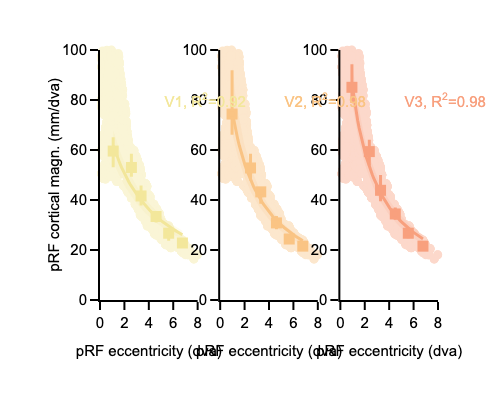

In [22]:
fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm_bins, 
                       data_pcm_raw=prf_CM_df, 
                       fig_width=1000, 
                       fig_height=400, 
                       rois=rois, 
                       roi_colors=roi_colors, 
                       plot_groups=plot_groups, 
                       max_ecc=max_ecc)

# fig.write_image("d /home/jovyan/projects/pRF-project_NH2025/ecc_pcm.pdf")

fig.show()


In [21]:
#  Imports
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np

def prf_ecc_pcm_plot(df_ecc_pcm, data_pcm_raw, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : dictionary with keys as roi and value correspondig rgb color
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """
    from math_utils import weighted_regression, weighted_nan_percentile, weighted_nan_median
    from sklearn.metrics import r2_score
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            pcm_median = np.array(df.prf_pcm_bins_median)
            r2_median = np.array(df.prf_r2_bins_median)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_median[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_median[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_median[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            
            
            # Filtrer les NaN dans les données
            valid_idx = ~np.isnan(pcm_median) & ~np.isnan(ecc_median)
            x_valid = ecc_median[valid_idx]
            y_valid = pcm_median[valid_idx]
            
            # Générer les prédictions avec ton modèle (y = 1/(cx + d))
            y_pred = 1 / (slope * x_valid + intercept)
            
            # Calculer R²
            r2 = r2_score(y_valid, y_pred)
            # Markers all point
            fig.add_trace(go.Scatter(x=data_pcm_raw['prf_ecc'], 
                                     y=data_pcm_raw['pRF_CM'], 
                                     mode='markers', 
                                     marker=dict(color=roi_color, 
                                                 symbol='circle', 
                                                 size=6, 
                                                 line=dict(color=roi_color, width=3)), 
                                     cliponaxis=False,
                                     showlegend=False, 
                                     opacity=0.4), 
                          row=1, col=l + 1)


            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)


            # Bin markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=pcm_median, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_median, 
                                                  arrayminus=pcm_median - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=5, y=80, text='{}, R<sup>2</sup>={:.2f}'.format(roi,r2), xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, 100], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)
        
    return fig